In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
import shap
import math
sys.path.append('../../stock_volatility')
from sklearn.model_selection import train_test_split
from utils.metrics_calculation import (
    cal_series_log_return,
    cal_realized_volatility,
    evaluation,
    root_mean_squared_percentage_error
)
from utils.baseline import (
    create_baseline_pred
)
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

shap.initjs()

# Import Data

In [2]:
book_df = pd.read_parquet('../data/book_train.parquet')
trade_df = pd.read_parquet('../data/trade_train.parquet')
response_df = pd.read_csv('../data/train.csv')

## Preprocess the data

In [3]:
book_df = cal_series_log_return(book_df)

In [4]:
def divide_data_into_part(df, n_sec):
    if 600%n_sec != 0:
        print("can not split data into equal part")
    divided_df = df.copy()
    divided_df.loc[:, "part"] = (np.ceil((df["seconds_in_bucket"] + 1)/n_sec)).apply(str)
    return(divided_df)

In [5]:
def cal_volume(ask_size1: float, ask_size2: float, bid_size1: float, bid_size2: float) -> float:
    ''' Function to calculate volume

    Args:
        ask_size1: Size of lowest asking price
        ask_size2: Size of lowest asking price
        bid_size1: Size of highest bidding price
        bid_size2: Size of highest bidding price

    Returns:
        average volume
    '''

    total_volume = 'ask_size1' + 'ask_size2' + 'bid_size1' + 'bid_size2'

    return total_volume


def cal_series_volume(book_df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to calculate volume of DataFrame


    Args:
        book_df: DataFrame contains booking information

    Returns:
        DataFrame contains booking information with wap
    '''

    book_df["volume"] = book_df["ask_size1"] + book_df["ask_size2"] + book_df["bid_size1"] + book_df["bid_size2"]
    book_df["normalize_volume"] = book_df["volume"] * book_df["wap"]
    book_df["delta_ask_bid"] = (book_df["ask_size1"] +  book_df["ask_size2"]) - (book_df["bid_size1"] + book_df["bid_size2"])
    book_df["normalize_delta_ask_bid"] = book_df["delta_ask_bid"] * book_df["wap"]

    return book_df


In [6]:
book_df = cal_series_volume(book_df)

In [7]:
splitted_book = divide_data_into_part(book_df, 50)

In [8]:
splitted_book

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return,volume,normalize_volume,delta_ask_bid,normalize_delta_ask_bid,part
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,1.001434,NaN,331,331.474518,321,321.460175,1.0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1.001448,0.000014,205,205.296799,195,195.282318,1.0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1.001448,0.000000,205,205.296799,195,195.282318,1.0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,-0.000005,231,231.333237,221,221.318802,1.0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443,0.000000,231,231.333237,221,221.318802,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167253284,32767,589,0.999662,0.999797,0.999527,0.999932,400,600,400,528,99,0.999716,-0.000064,1928,1927.452148,328,327.906799,12.0
167253285,32767,590,0.999662,0.999797,0.999527,0.999932,400,500,400,528,99,0.999722,0.000006,1828,1827.491699,228,227.936600,12.0
167253286,32767,592,0.999527,0.999797,0.999391,0.999932,900,600,600,528,99,0.999689,-0.000033,2628,2627.182129,-372,-371.884247,12.0
167253287,32767,596,0.999527,0.999797,0.999391,0.999932,900,700,600,628,99,0.999679,-0.000010,2828,2827.091309,-172,-171.944733,12.0


In [9]:
realized_volatility_per_part_stock_time = splitted_book.groupby(by=["time_id", "stock_id", "part"], sort=False)["log_return"].agg(
    cal_realized_volatility)
realized_volatility_per_part_stock_time = realized_volatility_per_part_stock_time.reset_index()

In [10]:
price_per_part_stock_time = splitted_book.groupby(by=["time_id", "stock_id", "part"], sort=False)["wap"].agg("mean")
price_per_part_stock_time = price_per_part_stock_time.reset_index()

In [11]:
volume_per_part_stock_time = splitted_book.groupby(by=["time_id", "stock_id", "part"], sort=False)["normalize_volume"].agg("mean")
volume_per_part_stock_time = volume_per_part_stock_time.reset_index()

In [12]:
delta_per_part_stock_time = splitted_book.groupby(by=["time_id", "stock_id", "part"], sort=False)["normalize_delta_ask_bid"].agg("mean")
delta_per_part_stock_time = delta_per_part_stock_time.reset_index()

Sort Part

In [13]:
realized_volatility_per_part_stock_time.loc[:, "part"] = realized_volatility_per_part_stock_time.loc[:, "part"].map(float)
price_per_part_stock_time.loc[:, "part"] = price_per_part_stock_time.loc[:, "part"].map(float)
volume_per_part_stock_time.loc[:, "part"] = volume_per_part_stock_time.loc[:, "part"].map(float)
delta_per_part_stock_time.loc[:, "part"] = delta_per_part_stock_time.loc[:, "part"].map(float)

In [14]:
realized_volatility_per_part_stock_time = realized_volatility_per_part_stock_time.sort_values(["stock_id", "time_id", "part"], ascending=[1, 1, 1])
price_per_part_stock_time = price_per_part_stock_time.sort_values(["stock_id", "time_id", "part"], ascending=[1, 1, 1])
volume_per_part_stock_time = volume_per_part_stock_time.sort_values(["stock_id", "time_id", "part"], ascending=[1, 1, 1])
delta_per_part_stock_time = delta_per_part_stock_time.sort_values(["stock_id", "time_id", "part"], ascending=[1, 1, 1])

Pivot table

In [15]:
X = pd.pivot_table(realized_volatility_per_part_stock_time, values="log_return", index=["stock_id", "time_id"], columns=['part'])

In [16]:
X = X.reset_index()
X.columns.name = None

In [17]:
X

,stock_id,time_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,5,0.001285,0.001503,0.001387,0.001683,0.001296,0.001083,0.001637,0.000869,0.001525,0.000914,0.001073,0.000989
1,0,11,0.000302,0.000243,0.000425,0.000303,0.000168,0.000196,0.000101,0.000283,0.000171,0.000329,0.000384,0.000766
2,0,16,0.000801,0.000325,0.000540,0.000900,0.000561,0.001331,0.000169,0.000508,0.000224,0.000964,0.000553,0.000323
3,0,31,0.000057,0.000331,0.001299,0.001176,0.000218,0.000489,0.000031,0.001466,0.000140,0.000109,0.000359,0.000919
4,0,62,0.000393,0.000905,0.000164,0.000346,0.000188,0.000351,0.000159,0.000476,0.000400,0.000797,0.000438,0.001035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99,32751,0.000208,0.000249,0.000098,0.000312,0.000154,0.000330,0.000435,0.000378,0.000751,0.000436,0.000619,0.000500
428928,99,32753,0.000390,0.000282,0.000095,0.000162,0.000418,0.001407,0.000430,0.000515,0.000293,0.000301,0.000384,0.000168
428929,99,32758,0.000250,0.000369,0.000438,0.000645,0.000477,0.000672,0.000554,0.000423,0.000594,0.000361,0.000276,0.000468
428930,99,32763,0.000616,0.000945,0.000638,0.000713,0.000700,0.000629,0.000657,0.000689,0.000647,0.000422,0.000426,0.000374


Add price

In [18]:
price = pd.pivot_table(price_per_part_stock_time, values="wap", index=["stock_id", "time_id"], columns=['part'])
price = price.reset_index()
price.columns.name = None

In [19]:
price.columns = ["stock_id", "time_id", "price1", "price2", "price3", "price4", "price5", "price6", "price7", "price8", "price9", "price10", "price11", "price12"]

Add volume

In [20]:
volume = pd.pivot_table(volume_per_part_stock_time, values="normalize_volume", index=["stock_id", "time_id"], columns=['part'])
volume = volume.reset_index()
volume.columns.name = None

In [21]:
volume.columns = ["stock_id", "time_id", "volume1", "volume2", "volume3", "volume4", "volume5", "volume6", "volume7", "volume8", "volume9", "volume10", "volume11", "volume12"]

Add delta

In [22]:
delta = pd.pivot_table(delta_per_part_stock_time, values="normalize_delta_ask_bid", index=["stock_id", "time_id"], columns=['part'])
delta = delta.reset_index()
delta.columns.name = None

In [23]:
delta.columns = ["stock_id", "time_id", "delta1", "delta2", "delta3", "delta4", "delta5", "delta6", "delta7", "delta8", "delta9", "delta10", "delta11", "delta12"]

Add t-1

In [24]:
trade_df

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
...,...,...,...,...,...,...
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99


In [25]:
t1 = response_df.loc[:, ["time_id", "stock_id"]]
t1.loc[:, "t1"] = create_baseline_pred(book_df, response_df)

In [26]:
X = X.merge(t1, on=["stock_id", "time_id"], how="left")

Add price and volumn

In [27]:
X = X.merge(price, on=["stock_id", "time_id"], how="left")
X = X.merge(volume, on=["stock_id", "time_id"], how="left")
X = X.merge(delta, on=["stock_id", "time_id"], how="left")

Total transaction

In [28]:
trade_df.loc[:, "total_transaction"] = trade_df.loc[:, "price"] * trade_df.loc[:, "size"]
trade_df.loc[:, "normalized_order_count"] = trade_df.loc[:, "price"] * trade_df.loc[:, "order_count"]

In [29]:
order_count_sum_df = trade_df.groupby(by=["time_id", "stock_id"]).agg({"total_transaction": [np.mean, np.std], "normalized_order_count": [np.mean, np.std]})
order_count_sum_df.columns = ["amount_trade", "trade_spread", "amount_order", "amount_spread"]
order_count_sum_df = order_count_sum_df.reset_index()

In [30]:
X = X.merge(order_count_sum_df, on=["stock_id", "time_id"], how="left")

Price as predictors

In [31]:
price_df = book_df.groupby(by=["time_id", "stock_id"]).agg({"wap": ["max", "min", "mean"]})
price_df.columns = ["max_price", "min_price", "mean_price"]

In [32]:
X = X.merge(price_df, on=["stock_id", "time_id"], how="left")

In [33]:
y = response_df["target"]

In [34]:
X

,stock_id,time_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,delta10,delta11,delta12,amount_trade,trade_spread,amount_order,amount_spread,max_price,min_price,mean_price
0,0,5,0.001285,0.001503,0.001387,0.001683,0.001296,0.001083,0.001637,0.000869,...,-112.492714,94.498001,-4.369401,79.753479,118.778415,2.759680,2.475064,1.004920,1.001434,1.003725
1,0,11,0.000302,0.000243,0.000425,0.000303,0.000168,0.000196,0.000101,0.000283,...,-55.784283,-48.392605,-71.984657,42.978447,77.834930,1.900448,1.447273,1.000834,0.999700,1.000239
2,0,16,0.000801,0.000325,0.000540,0.000900,0.000561,0.001331,0.000169,0.000508,...,122.894196,138.870132,146.762833,86.344360,113.450182,2.717500,2.298385,1.000878,0.997224,0.999542
3,0,31,0.000057,0.000331,0.001299,0.001176,0.000218,0.000489,0.000031,0.001466,...,30.941082,-96.288628,287.471191,130.640366,144.598250,3.928791,4.038337,1.000412,0.997447,0.998832
4,0,62,0.000393,0.000905,0.000164,0.000346,0.000188,0.000351,0.000159,0.000476,...,-120.643250,-30.989571,-125.819611,81.375206,117.861342,4.043890,4.098106,1.000159,0.999231,0.999619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99,32751,0.000208,0.000249,0.000098,0.000312,0.000154,0.000330,0.000435,0.000378,...,369.279297,-340.582916,-59.732731,475.013977,534.415205,4.799252,4.601413,1.001303,0.999641,1.000644
428928,99,32753,0.000390,0.000282,0.000095,0.000162,0.000418,0.001407,0.000430,0.000515,...,872.180725,769.870117,787.118652,528.960571,718.360040,6.363010,6.739449,1.002139,0.999517,1.000509
428929,99,32758,0.000250,0.000369,0.000438,0.000645,0.000477,0.000672,0.000554,0.000423,...,-264.308258,-1180.569702,-1584.042358,599.342712,1175.595278,5.430646,7.475390,0.999939,0.997477,0.998350
428930,99,32763,0.000616,0.000945,0.000638,0.000713,0.000700,0.000629,0.000657,0.000689,...,2017.087036,2687.333252,651.945801,282.953644,372.360766,3.538350,3.245132,0.999940,0.998146,0.998897


In [35]:
response_df.loc[:, ["stock_id", "time_id"]]

,stock_id,time_id
0,0,5
1,0,11
2,0,16
3,0,31
4,0,62
...,...,...
428927,126,32751
428928,126,32753
428929,126,32758
428930,126,32763


In [36]:
df = X.merge(response_df, on=["stock_id", "time_id"], how="left")

In [37]:
df

,stock_id,time_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,delta11,delta12,amount_trade,trade_spread,amount_order,amount_spread,max_price,min_price,mean_price,target
0,0,5,0.001285,0.001503,0.001387,0.001683,0.001296,0.001083,0.001637,0.000869,...,94.498001,-4.369401,79.753479,118.778415,2.759680,2.475064,1.004920,1.001434,1.003725,0.004136
1,0,11,0.000302,0.000243,0.000425,0.000303,0.000168,0.000196,0.000101,0.000283,...,-48.392605,-71.984657,42.978447,77.834930,1.900448,1.447273,1.000834,0.999700,1.000239,0.001445
2,0,16,0.000801,0.000325,0.000540,0.000900,0.000561,0.001331,0.000169,0.000508,...,138.870132,146.762833,86.344360,113.450182,2.717500,2.298385,1.000878,0.997224,0.999542,0.002168
3,0,31,0.000057,0.000331,0.001299,0.001176,0.000218,0.000489,0.000031,0.001466,...,-96.288628,287.471191,130.640366,144.598250,3.928791,4.038337,1.000412,0.997447,0.998832,0.002195
4,0,62,0.000393,0.000905,0.000164,0.000346,0.000188,0.000351,0.000159,0.000476,...,-30.989571,-125.819611,81.375206,117.861342,4.043890,4.098106,1.000159,0.999231,0.999619,0.001747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99,32751,0.000208,0.000249,0.000098,0.000312,0.000154,0.000330,0.000435,0.000378,...,-340.582916,-59.732731,475.013977,534.415205,4.799252,4.601413,1.001303,0.999641,1.000644,0.001279
428928,99,32753,0.000390,0.000282,0.000095,0.000162,0.000418,0.001407,0.000430,0.000515,...,769.870117,787.118652,528.960571,718.360040,6.363010,6.739449,1.002139,0.999517,1.000509,0.000890
428929,99,32758,0.000250,0.000369,0.000438,0.000645,0.000477,0.000672,0.000554,0.000423,...,-1180.569702,-1584.042358,599.342712,1175.595278,5.430646,7.475390,0.999939,0.997477,0.998350,0.001782
428930,99,32763,0.000616,0.000945,0.000638,0.000713,0.000700,0.000629,0.000657,0.000689,...,2687.333252,651.945801,282.953644,372.360766,3.538350,3.245132,0.999940,0.998146,0.998897,0.003100


In [38]:
y = df["target"]

In [39]:
df

,stock_id,time_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,delta11,delta12,amount_trade,trade_spread,amount_order,amount_spread,max_price,min_price,mean_price,target
0,0,5,0.001285,0.001503,0.001387,0.001683,0.001296,0.001083,0.001637,0.000869,...,94.498001,-4.369401,79.753479,118.778415,2.759680,2.475064,1.004920,1.001434,1.003725,0.004136
1,0,11,0.000302,0.000243,0.000425,0.000303,0.000168,0.000196,0.000101,0.000283,...,-48.392605,-71.984657,42.978447,77.834930,1.900448,1.447273,1.000834,0.999700,1.000239,0.001445
2,0,16,0.000801,0.000325,0.000540,0.000900,0.000561,0.001331,0.000169,0.000508,...,138.870132,146.762833,86.344360,113.450182,2.717500,2.298385,1.000878,0.997224,0.999542,0.002168
3,0,31,0.000057,0.000331,0.001299,0.001176,0.000218,0.000489,0.000031,0.001466,...,-96.288628,287.471191,130.640366,144.598250,3.928791,4.038337,1.000412,0.997447,0.998832,0.002195
4,0,62,0.000393,0.000905,0.000164,0.000346,0.000188,0.000351,0.000159,0.000476,...,-30.989571,-125.819611,81.375206,117.861342,4.043890,4.098106,1.000159,0.999231,0.999619,0.001747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99,32751,0.000208,0.000249,0.000098,0.000312,0.000154,0.000330,0.000435,0.000378,...,-340.582916,-59.732731,475.013977,534.415205,4.799252,4.601413,1.001303,0.999641,1.000644,0.001279
428928,99,32753,0.000390,0.000282,0.000095,0.000162,0.000418,0.001407,0.000430,0.000515,...,769.870117,787.118652,528.960571,718.360040,6.363010,6.739449,1.002139,0.999517,1.000509,0.000890
428929,99,32758,0.000250,0.000369,0.000438,0.000645,0.000477,0.000672,0.000554,0.000423,...,-1180.569702,-1584.042358,599.342712,1175.595278,5.430646,7.475390,0.999939,0.997477,0.998350,0.001782
428930,99,32763,0.000616,0.000945,0.000638,0.000713,0.000700,0.000629,0.000657,0.000689,...,2687.333252,651.945801,282.953644,372.360766,3.538350,3.245132,0.999940,0.998146,0.998897,0.003100


In [40]:
X = df[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, "t1","amount_trade", "max_price", "min_price", "mean_price"]]
X

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,t1,amount_trade,max_price,min_price,mean_price
0,0.001285,0.001503,0.001387,0.001683,0.001296,0.001083,0.001637,0.000869,0.001525,0.000914,0.001073,0.000989,0.004499,79.753479,1.004920,1.001434,1.003725
1,0.000302,0.000243,0.000425,0.000303,0.000168,0.000196,0.000101,0.000283,0.000171,0.000329,0.000384,0.000766,0.001204,42.978447,1.000834,0.999700,1.000239
2,0.000801,0.000325,0.000540,0.000900,0.000561,0.001331,0.000169,0.000508,0.000224,0.000964,0.000553,0.000323,0.002369,86.344360,1.000878,0.997224,0.999542
3,0.000057,0.000331,0.001299,0.001176,0.000218,0.000489,0.000031,0.001466,0.000140,0.000109,0.000359,0.000919,0.002574,130.640366,1.000412,0.997447,0.998832
4,0.000393,0.000905,0.000164,0.000346,0.000188,0.000351,0.000159,0.000476,0.000400,0.000797,0.000438,0.001035,0.001894,81.375206,1.000159,0.999231,0.999619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.000208,0.000249,0.000098,0.000312,0.000154,0.000330,0.000435,0.000378,0.000751,0.000436,0.000619,0.000500,0.001436,475.013977,1.001303,0.999641,1.000644
428928,0.000390,0.000282,0.000095,0.000162,0.000418,0.001407,0.000430,0.000515,0.000293,0.000301,0.000384,0.000168,0.001795,528.960571,1.002139,0.999517,1.000509
428929,0.000250,0.000369,0.000438,0.000645,0.000477,0.000672,0.000554,0.000423,0.000594,0.000361,0.000276,0.000468,0.001658,599.342712,0.999939,0.997477,0.998350
428930,0.000616,0.000945,0.000638,0.000713,0.000700,0.000629,0.000657,0.000689,0.000647,0.000422,0.000426,0.000374,0.002213,282.953644,0.999940,0.998146,0.998897


## Modeling

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [43]:
params = {
    'objective':'reg:squarederror',
    'max_depth': 15, 
    'colsample_bylevel':0.8,
    'learning_rate':0.05,
    'random_state':42
}
eval_set = [(X_val, y_val)]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round = 999,
    evals=[(dval, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.47133
[1]	Test-rmse:0.44776
[2]	Test-rmse:0.42538
[3]	Test-rmse:0.40411
[4]	Test-rmse:0.38390
[5]	Test-rmse:0.36471
[6]	Test-rmse:0.34647
[7]	Test-rmse:0.32915
[8]	Test-rmse:0.31269
[9]	Test-rmse:0.29706
[10]	Test-rmse:0.28221
[11]	Test-rmse:0.26810
[12]	Test-rmse:0.25470
[13]	Test-rmse:0.24196
[14]	Test-rmse:0.22986
[15]	Test-rmse:0.21837
[16]	Test-rmse:0.20745
[17]	Test-rmse:0.19708
[18]	Test-rmse:0.18723
[19]	Test-rmse:0.17787
[20]	Test-rmse:0.16898
[21]	Test-rmse:0.16053
[22]	Test-rmse:0.15250
[23]	Test-rmse:0.14488
[24]	Test-rmse:0.13764
[25]	Test-rmse:0.13076
[26]	Test-rmse:0.12422
[27]	Test-rmse:0.11801
[28]	Test-rmse:0.11211
[29]	Test-rmse:0.10651
[30]	Test-rmse:0.10118
[31]	Test-rmse:0.09612
[32]	Test-rmse:0.09132
[33]	Test-rmse:0.08675
[34]	Test-rmse:0.08242
[35]	Test-rmse:0.07830
[36]	Test-rmse:0.07438
[37]	Test-rmse:0.07067
[38]	Test-rmse:0.06714
[39]	Test-rmse:0.06378
[40]	Test-rmse:0.06059
[41]	Test-rmse:0.05756
[42]	Test-rmse:0.05469
[43]	Test-rmse:0.0519

In [44]:
xgb_y_pred = xgb_model.predict(dtest)
xgb_pred_result = evaluation(y_test, xgb_y_pred)
xgb_pred_result

{'residual': 58607    -0.002215
 356864   -0.004455
 197966   -0.001382
 261134   -0.000636
 193238    0.000080
             ...   
 1792     -0.000557
 75578    -0.000263
 86262     0.000271
 336477   -0.002483
 80054     0.000225
 Name: target, Length: 85787, dtype: float64,
 'true_average': 0.003887170312063601,
 'prediction_average': 0.003918594,
 'sum_error': 2.695748512563613,
 'average_error': 3.142390300163965e-05,
 'mae': 0.0007730191759631974,
 'rmse': 0.0013048466046079192,
 'rmspe': 28.638374930425464,
 'smape': 19.39640682120923,
 'r2': 0.7999011974411443}

In [45]:
# explainer = shap.Explainer(xgb_model)
# shap_values = explainer(X_train)
# shap.plots.beeswarm(shap_values, max_display=20)

### Good try for first model iteration, we can push it further

In [46]:
df.loc[:, "3t1_1"] = np.sqrt((np.square(df[[1.0, 2.0, 3.0]])).sum(axis=1))
df.loc[:, "3t1_2"] = np.sqrt((np.square(df[[4.0, 5.0, 6.0]])).sum(axis=1))
df.loc[:, "3t1_3"] = np.sqrt((np.square(df[[7.0, 8.0, 9.0]])).sum(axis=1))
df.loc[:, "3t1_4"] = np.sqrt((np.square(df[[10.0, 11.0, 12.0]])).sum(axis=1))
df.loc[:, "4t1_1"] = np.sqrt((np.square(df[[1.0, 2.0, 3.0, 4.0]])).sum(axis=1))
df.loc[:, "4t1_2"] = np.sqrt((np.square(df[[5.0, 6.0, 7.0, 8.0]])).sum(axis=1))
df.loc[:, "4t1_3"] = np.sqrt((np.square(df[[9.0, 10.0, 11.0, 12.0]])).sum(axis=1))
df.loc[:, "6t1_1"] = np.sqrt((np.square(df[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]])).sum(axis=1))
df.loc[:, "6t1_2"] = np.sqrt((np.square(df[[7.0, 8.0, 9.0, 10.0, 11.0, 12.0]])).sum(axis=1))

In [47]:
df.loc[:, "3diff_12"] = df["3t1_2"] - df["3t1_1"]
df.loc[:, "3diff_23"] = df["3t1_3"] - df["3t1_2"]
df.loc[:, "3diff_34"] = df["3t1_4"] - df["3t1_3"]
df.loc[:, "3diff_14"] = df["3t1_4"] - df["3t1_1"]
df.loc[:, "6diff_12"] = df["6t1_2"] - df["6t1_1"]

In [48]:
df.loc[:, "diff_6t1_2_t1"] = df["t1"] - df["6t1_2"]

### Add price as preditors

In [49]:
df.loc[:, "3p_1"] = np.mean(df[["price1", "price2", "price3"]], axis=1)
df.loc[:, "3p_2"] = np.mean(df[["price4", "price5", "price6"]], axis=1)
df.loc[:, "3p_3"] = np.mean(df[["price7", "price8", "price9"]], axis=1)
df.loc[:, "3p_4"] = np.mean(df[["price10", "price11", "price12"]], axis=1)
df.loc[:, "4p_1"] = np.mean(df[["price1", "price2", "price3", "price4"]], axis=1)
df.loc[:, "4p_2"] = np.mean(df[["price5", "price6", "price7", "price8"]], axis=1)
df.loc[:, "4p_3"] = np.mean(df[["price9", "price10", "price11", "price12"]], axis=1)
df.loc[:, "6p_1"] = np.mean(df[["price1", "price2", "price3", "price4", "price5", "price6"]], axis=1)
df.loc[:, "6p_2"] = np.mean(df[["price7", "price8", "price9", "price10", "price11", "price12"]], axis=1)
df.loc[:, "mean_p"] = np.mean(df[["price1", "price2", "price3", "price4", "price5", "price6", "price8", "price9", "price10", "price11", "price12"]], axis=1)
df.loc[:, "sum_p"] = np.sum(df[["price1", "price2", "price3", "price4", "price5", "price6", "price7", "price8", "price9", "price10", "price11", "price12"]], axis=1)

In [50]:
df.loc[:, "p_3diff_12"] = df["3p_1"] - df["3p_2"]
df.loc[:, "p_3diff_23"] = df["3p_2"] - df["3p_3"]
df.loc[:, "p_3diff_34"] = df["3p_3"] - df["3p_4"]
df.loc[:, "p_3diff_14"] = df["3p_1"] - df["3p_4"]
df.loc[:, "p_6diff_12"] = df["6p_1"] - df["6p_2"]

### Add volume as preditors

In [51]:
df.loc[:, "3v_1"] = np.mean(df[["volume1", "volume2", "volume3"]], axis=1)
df.loc[:, "3v_2"] = np.mean(df[["volume4", "volume5", "volume6"]], axis=1)
df.loc[:, "3v_3"] = np.mean(df[["volume7", "volume8", "volume9"]], axis=1)
df.loc[:, "3v_4"] = np.mean(df[["volume10", "volume11", "volume12"]], axis=1)
df.loc[:, "4v_1"] = np.mean(df[["volume1", "volume2", "volume3", "volume4"]], axis=1)
df.loc[:, "4v_2"] = np.mean(df[["volume5", "volume6", "volume7", "volume8"]], axis=1)
df.loc[:, "4v_3"] = np.mean(df[["volume9", "volume10", "volume11", "volume12"]], axis=1)
df.loc[:, "6v_1"] = np.mean(df[["volume1", "volume2", "volume3", "volume4", "volume5", "volume6"]], axis=1)
df.loc[:, "6v_2"] = np.mean(df[["volume7", "volume8", "volume9", "volume10", "volume11", "volume12"]], axis=1)
df.loc[:, "mean_v"] = np.mean(df[["volume1", "volume2", "volume3", "volume4", "volume5", "volume6", "volume7", "volume8", "volume9", "volume10", "volume11", "volume12"]], axis=1)
df.loc[:, "sum_v"] = np.sum(df[["volume1", "volume2", "volume3", "volume4", "volume5", "volume6", "volume7", "volume8", "volume9", "volume10", "volume11", "volume12"]], axis=1)

In [52]:
df.loc[:, "v_3diff_12"] = df["3v_1"] - df["3v_2"]
df.loc[:, "v_3diff_23"] = df["3v_2"] - df["3v_3"]
df.loc[:, "v_3diff_34"] = df["3v_3"] - df["3v_4"]
df.loc[:, "v_3diff_14"] = df["3v_1"] - df["3v_4"]
df.loc[:, "v_6diff_12"] = df["6v_1"] - df["6v_2"]

### Add delta as preditors

In [53]:
df.loc[:, "6d_1"] = np.mean(df[["delta1", "delta2", "delta3", "delta4", "delta5", "delta6"]], axis=1)
df.loc[:, "6d_2"] = np.mean(df[["delta7", "delta8", "delta9", "delta10", "delta11", "delta12"]], axis=1)

### Add stock_id as category variable

In [54]:
df.loc[:, "stock_id"] = df["stock_id"].astype('category')
df.loc[:, "stock_id"] = df["stock_id"].cat.codes

### fitting "trend line" in

In [55]:
def trend_line(df):
    X_ols = sm.add_constant(df.loc[:, "t1"])
    X_ols.loc[:, "t1_square"] = np.square(X_ols.loc[:, "t1"])
    model = sm.OLS(y, X_ols)
    ols = model.fit()
    trend_line_array = ols.predict(X_ols)
    return ols.summary(), trend_line_array

In [56]:
ols_results, trend_line_array = trend_line(df)

In [57]:
df.loc[:, "trend_line"] = trend_line_array

In [58]:
X = df[["stock_id", "trend_line",
        "3t1_1", "3t1_2", "3t1_3", "3t1_4", "4t1_1", "4t1_2", "4t1_3","6t1_1", "6t1_2",
        "3diff_14", "3diff_34", "6diff_12",
        "diff_6t1_2_t1",
        "3p_3", "3p_4", "4p_3","6p_1", "6p_2",
        "mean_p",
        "p_6diff_12",
        "3v_4", "4v_3","6v_1", "6v_2",
        "mean_v", 
        "v_6diff_12",
        "6d_1", "6d_2",
        "amount_trade", "amount_order", "trade_spread", "amount_spread"]]
X

,stock_id,trend_line,3t1_1,3t1_2,3t1_3,3t1_4,4t1_1,4t1_2,4t1_3,6t1_1,...,6v_1,6v_2,mean_v,v_6diff_12,6d_1,6d_2,amount_trade,amount_order,trade_spread,amount_spread
0,0,0.004200,0.002416,0.002385,0.002400,0.001722,0.002944,0.002507,0.002300,0.003394,...,337.352264,298.659576,318.005920,38.692688,2.479285,15.783282,79.753479,2.759680,118.778415,2.475064
1,0,0.001448,0.000575,0.000398,0.000345,0.000918,0.000650,0.000396,0.000934,0.000699,...,313.240570,481.182098,397.211334,-167.941528,-60.632923,-81.610695,42.978447,1.900448,77.834930,1.447273
2,0,0.002440,0.001019,0.001702,0.000580,0.001158,0.001359,0.001540,0.001179,0.001983,...,395.329468,432.887085,414.108276,-37.557617,-44.073383,64.653908,86.344360,2.717500,113.450182,2.298385
3,0,0.002612,0.001342,0.001292,0.001473,0.000993,0.001784,0.001561,0.001003,0.001863,...,458.781860,437.315216,448.048584,21.466644,86.505653,59.553177,130.640366,3.928791,144.598250,4.038337
4,0,0.002038,0.001000,0.000528,0.000642,0.001378,0.001058,0.000641,0.001434,0.001131,...,277.799805,403.289429,340.544586,-125.489624,-92.632072,-44.980377,81.375206,4.043890,117.861342,4.098106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,87,0.001647,0.000339,0.000480,0.000946,0.000907,0.000461,0.000681,0.001177,0.000587,...,3858.824219,2410.798096,3134.811279,1448.026123,-364.578369,122.952850,475.013977,4.799252,534.415205,4.601413
428928,87,0.001954,0.000491,0.001476,0.000732,0.000516,0.000517,0.001613,0.000594,0.001556,...,2819.450439,1820.246460,2319.848633,999.203979,939.435852,482.139496,528.960571,6.363010,718.360040,6.739449
428929,87,0.001837,0.000625,0.001047,0.000916,0.000652,0.000898,0.001079,0.000882,0.001219,...,3588.954102,3275.813232,3432.383545,313.140869,-329.777313,-425.898071,599.342712,5.430646,1175.595278,7.475390
428930,87,0.002308,0.001296,0.001181,0.001151,0.000707,0.001479,0.001339,0.000958,0.001753,...,1571.270630,2312.579834,1941.925171,-741.309204,548.949524,1207.457275,282.953644,3.538350,372.360766,3.245132


In [59]:
X = df[["stock_id", 
        "3t1_1", "3t1_2", "3t1_3", "3t1_4","6t1_1", "6t1_2",
        "3diff_14", "3diff_34", "6diff_12",
        "3p_3", "3p_4", "4p_3","6p_1", "6p_2",
        "mean_p",
        "p_6diff_12",
        "3v_4", "4v_3","6v_1", "6v_2",
        "mean_v", 
        "v_6diff_12",
        "amount_trade", "amount_order", "trade_spread", "amount_spread"]]
X

,stock_id,3t1_1,3t1_2,3t1_3,3t1_4,6t1_1,6t1_2,3diff_14,3diff_34,6diff_12,...,3v_4,4v_3,6v_1,6v_2,mean_v,v_6diff_12,amount_trade,amount_order,trade_spread,amount_spread
0,0,0.002416,0.002385,0.002400,0.001722,0.003394,0.002953,-0.000694,-0.000678,-0.000441,...,265.138824,263.911652,337.352264,298.659576,318.005920,38.692688,79.753479,2.759680,118.778415,2.475064
1,0,0.000575,0.000398,0.000345,0.000918,0.000699,0.000981,0.000343,0.000572,0.000282,...,457.267548,485.752258,313.240570,481.182098,397.211334,-167.941528,42.978447,1.900448,77.834930,1.447273
2,0,0.001019,0.001702,0.000580,0.001158,0.001983,0.001295,0.000139,0.000577,-0.000689,...,451.432648,443.945587,395.329468,432.887085,414.108276,-37.557617,86.344360,2.717500,113.450182,2.298385
3,0,0.001342,0.001292,0.001473,0.000993,0.001863,0.001776,-0.000349,-0.000480,-0.000087,...,526.709656,482.663452,458.781860,437.315216,448.048584,21.466644,130.640366,3.928791,144.598250,4.038337
4,0,0.001000,0.000528,0.000642,0.001378,0.001131,0.001520,0.000377,0.000736,0.000389,...,379.935699,345.271149,277.799805,403.289429,340.544586,-125.489624,81.375206,4.043890,117.861342,4.098106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,87,0.000339,0.000480,0.000946,0.000907,0.000587,0.001311,0.000568,-0.000039,0.000723,...,2275.485596,2301.317871,3858.824219,2410.798096,3134.811279,1448.026123,475.013977,4.799252,534.415205,4.601413
428928,87,0.000491,0.001476,0.000732,0.000516,0.001556,0.000896,0.000026,-0.000215,-0.000660,...,2191.885498,2058.836670,2819.450439,1820.246460,2319.848633,999.203979,528.960571,6.363010,718.360040,6.739449
428929,87,0.000625,0.001047,0.000916,0.000652,0.001219,0.001125,0.000028,-0.000264,-0.000094,...,3611.553467,3428.251709,3588.954102,3275.813232,3432.383545,313.140869,599.342712,5.430646,1175.595278,7.475390
428930,87,0.001296,0.001181,0.001151,0.000707,0.001753,0.001351,-0.000589,-0.000444,-0.000402,...,3015.213135,2735.146973,1571.270630,2312.579834,1941.925171,-741.309204,282.953644,3.538350,372.360766,3.245132


In [60]:
def xgb_feval_rmspe(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'RMSPE', root_mean_squared_percentage_error(y_true, y_pred, percentage=True)

In [61]:
def lgb_feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', root_mean_squared_percentage_error(y_true, y_pred, percentage=True), False

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [63]:
train_weights = 1 / np.square(y_train)
val_weights = 1 / np.square(y_val)
test_weights = 1 / np.square(y_test)

In [64]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, weight=train_weights)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True, weight=val_weights)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True, weight=test_weights)

In [65]:
x_params = {
    'booster':'gbtree',
    'objective':'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': 6,
    'grow_policy':'lossguide',
    'subsample': 0.9,
    'colsample_bylevel':0.85,
    'colsample_bytree':0.85,
    'lambda': 0.85,
    'alpha': 0.01,
    'learning_rate':0.05,
    'random_state':42
}
xgb_model = xgb.train(
    x_params,
    dtrain,
    num_boost_round = 999,
    feval= xgb_feval_rmspe,
    evals=[(dtrain, 'dtrain'), (dval, 'dval')],
    verbose_eval = 50,
    early_stopping_rounds=10
)

[0]	dtrain-rmse:0.47330	dtrain-RMSPE:21935.16693	dval-rmse:0.47329	dval-RMSPE:21918.61420
[50]	dtrain-rmse:0.03642	dtrain-RMSPE:1687.99686	dval-rmse:0.03643	dval-RMSPE:1687.05750
[100]	dtrain-rmse:0.00285	dtrain-RMSPE:132.04083	dval-rmse:0.00286	dval-RMSPE:132.55869
[150]	dtrain-rmse:0.00055	dtrain-RMSPE:25.59590	dval-rmse:0.00057	dval-RMSPE:26.60334
[200]	dtrain-rmse:0.00050	dtrain-RMSPE:23.37076	dval-rmse:0.00053	dval-RMSPE:24.44033
[218]	dtrain-rmse:0.00050	dtrain-RMSPE:23.30309	dval-rmse:0.00053	dval-RMSPE:24.42528


In [66]:
xgb_y_pred = xgb_model.predict(dtest)
xgb_pred_result = evaluation(y_test, xgb_y_pred)
xgb_pred_result

{'residual': 58607    -0.004494
 356864   -0.004835
 197966   -0.001543
 261134   -0.001501
 193238   -0.000104
             ...   
 1792     -0.000921
 75578    -0.000922
 86262     0.000111
 336477   -0.003009
 80054    -0.000151
 Name: target, Length: 85787, dtype: float64,
 'true_average': 0.003887170312063601,
 'prediction_average': 0.0034302317,
 'sum_error': -39.19939395789375,
 'average_error': -0.00045693860489299555,
 'mae': 0.0008051137425029644,
 'rmse': 0.0015002266395375626,
 'rmspe': 24.309489263074006,
 'smape': 19.679544107205725,
 'r2': 0.7354916928525856}

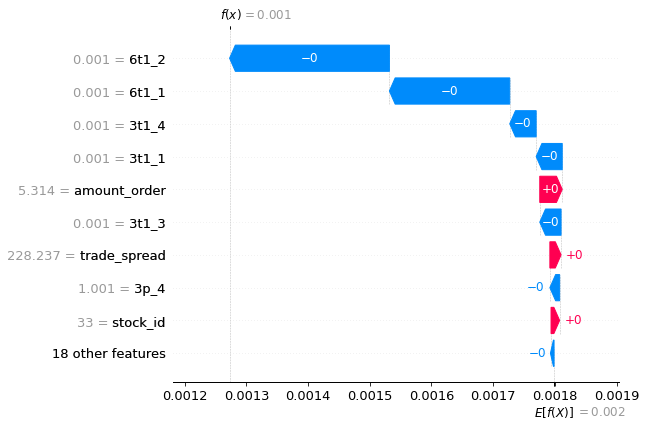

In [67]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

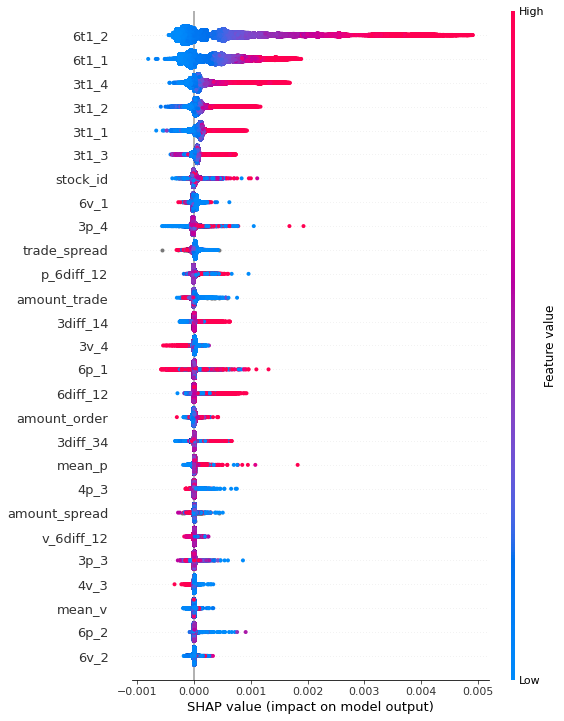

In [68]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=30)

In [69]:
l_params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }

In [70]:
ltrain = lgb.Dataset(X_train, label=y_train, weight = train_weights)
lval = lgb.Dataset(X_val, label=y_val, weight = val_weights)
ltest = lgb.Dataset(X_test, label=y_test, weight = test_weights)

In [71]:
lgb_model = lgb.train(l_params,
                      num_boost_round=1400,
                      train_set = ltrain,
                      valid_sets = lval,
                      feval= lgb_feval_rmspe,
                      verbose_eval = 250,
                      early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds
[250]	valid_0's rmse: 0.000513123	valid_0's RMSPE: 23.7633
Early stopping, best iteration is:
[319]	valid_0's rmse: 0.000512875	valid_0's RMSPE: 23.7518


In [72]:
lgb_y_pred = lgb_model.predict(X_test)
lgb_pred_result = evaluation(y_test, lgb_y_pred)
lgb_pred_result

{'residual': 58607    -0.004102
 356864   -0.004748
 197966   -0.001611
 261134   -0.001718
 193238   -0.000108
             ...   
 1792     -0.000954
 75578    -0.000780
 86262     0.000089
 336477   -0.003042
 80054    -0.000089
 Name: target, Length: 85787, dtype: float64,
 'true_average': 0.003887170312063601,
 'prediction_average': 0.003447393965980132,
 'sum_error': -37.72709340146242,
 'average_error': -0.0004397763460834694,
 'mae': 0.0007823655218217302,
 'rmse': 0.0014114501534242363,
 'rmspe': 23.7750282753669,
 'smape': 19.48991099813962,
 'r2': 0.7658702180566261}

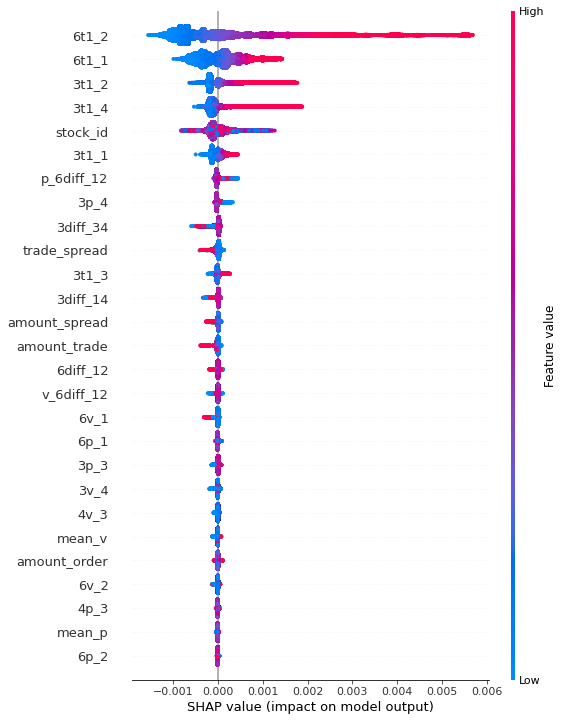

In [73]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=30)

## Finally use kfold

In [74]:
from sklearn.model_selection import KFold

In [75]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# Iterate through each fold
for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
    print(f'Training fold {fold + 1}')
    x_train, x_val = X.iloc[trn_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True, weight=train_weights)
    dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True, weight=val_weights)
    
    xgb_model = xgb.train( x_params,
                            dtrain,
                            num_boost_round = 999,
                            feval= xgb_feval_rmspe,
                            evals=[(dtrain, 'dtrain'), (dval, 'dval')],
                            early_stopping_rounds=10,
                            verbose_eval=50
                            )

Training fold 1
[0]	dtrain-rmse:0.47330	dtrain-RMSPE:21931.03485	dval-rmse:0.47328	dval-RMSPE:21798.16132
[50]	dtrain-rmse:0.03642	dtrain-RMSPE:1687.67223	dval-rmse:0.03642	dval-RMSPE:1677.54002
[100]	dtrain-rmse:0.00285	dtrain-RMSPE:132.02462	dval-rmse:0.00286	dval-RMSPE:131.55941
[150]	dtrain-rmse:0.00055	dtrain-RMSPE:25.66080	dval-rmse:0.00057	dval-RMSPE:26.35264
[200]	dtrain-rmse:0.00051	dtrain-RMSPE:23.48455	dval-rmse:0.00053	dval-RMSPE:24.29005
[231]	dtrain-rmse:0.00051	dtrain-RMSPE:23.38390	dval-rmse:0.00053	dval-RMSPE:24.28071
Training fold 2
[0]	dtrain-rmse:0.47329	dtrain-RMSPE:21875.86822	dval-rmse:0.47330	dval-RMSPE:22018.76831
[50]	dtrain-rmse:0.03642	dtrain-RMSPE:1683.43239	dval-rmse:0.03643	dval-RMSPE:1694.82441
[100]	dtrain-rmse:0.00285	dtrain-RMSPE:131.70561	dval-rmse:0.00286	dval-RMSPE:133.13160
[150]	dtrain-rmse:0.00056	dtrain-RMSPE:25.65065	dval-rmse:0.00057	dval-RMSPE:26.52202
[200]	dtrain-rmse:0.00051	dtrain-RMSPE:23.50915	dval-rmse:0.00052	dval-RMSPE:24.37825
[213

In [76]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# Iterate through each fold
for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
    print(f'Training fold {fold + 1}')
    x_train, x_val = X.iloc[trn_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights)
    val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights)
    
    lgb_model = lgb.train(params = l_params,
                      num_boost_round=1200,
                      train_set = train_dataset, 
                      valid_sets = [train_dataset, val_dataset], 
                      verbose_eval = 250,
                      early_stopping_rounds=50,
                      feval = lgb_feval_rmspe)

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000501515	training's RMSPE: 23.2387	valid_1's rmse: 0.000515946	valid_1's RMSPE: 23.7634
[500]	training's rmse: 0.000494946	training's RMSPE: 22.9343	valid_1's rmse: 0.000514841	valid_1's RMSPE: 23.7125
Early stopping, best iteration is:
[461]	training's rmse: 0.000495763	training's RMSPE: 22.9721	valid_1's rmse: 0.000514608	valid_1's RMSPE: 23.7018
Training fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	training's rmse: 0.000506697	training's RMSPE: 23.42	valid_1's rmse: 0.000512273	valid_1's RMSPE: 23.8318
Training fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	training's rmse: 0.000504457	training's RMSPE: 23.3707	valid_1's rmse: 0.00051893	valid_1's RMSPE: 23.9185
Training fold 4
Training until validation scores don't improve for 50 rounds
[250]	training's rms